In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/nlp_liflow/

/content/drive/My Drive/nlp_liflow


In [3]:
!ls

자연어처리_1.ipynb		  item_all_정치.csv
자연어처리_2.ipynb		  item_all_방송_연예.csv
all_df_with_tokens.csv		  item_all_스포츠.csv
all_sen.csv			  item_all_재테크.csv
cc.ko.300.bin.gz		  item_all_직장.csv
data.csv			  item_all_음식.csv
df_all				  item_all_건강.csv
df_all.csv			  item_all_자동차.csv
df_all_GloVe.csv		  item_all_다이어트.csv
df_all_tfidf.csv		  item_all_취미생활.csv
doc2vec_100.model		  item_all.csv
feature.pkl			  item_all_doc2vec_k-means.csv
feature.pkl.mtx			  item_all_GloVe_DBSCAN.csv
final_trainingset_자녀.csv	  item_all_glove_k-means.csv
final_trainingset_자동차.csv	  ko.bin
final_trainingset_sports.csv	  list_to_csv.csv
first_embedding_clustering.model  nlp_tokenizer.ipynb
glove_model_100.model		  스포츠_sen.csv
glove_model.model		  sen.csv
glove_word_dict_128.pickle	  sen_preprocessig.csv
item_1.csv			  스포츠_sen_prerprocessing.csv
item_all_자녀.csv		  sentence_Summarizer.ipynb
item_all_노후.csv		  textrank
item_all_국가_지역.csv		  textrank_g

In [4]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-12-19 04:45:36--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-12-19 04:45:36--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uced2cd6172a44d62b909198c714.dl.dropboxusercontent.com/cd/0/get/By49rFcu-5xEhHHjjlrRHbFMmevkizebBf-fCCl87po16Ls4ayMGTZutrtphO0jgu9vVm2DZKINDoanXF_va90ftMQGNEodWRRFkFZzJNA22XF3JkB7QkWu81xo-Qp4HFxZFQJW3lctQFY3O87eIcFyE-KveK6JgtjW3IliSUAf5Qsh9TXm_wBP_0Zfk5HjdP4g/file?dl=1# [following]
--2022-12-19 04:45:37--  https://uced2cd6172a44d62b909198c714.dl.dropboxusercontent.com/cd/0/get/By49rFcu-5xE

In [5]:
import textrank_git
from textrank_git import rank
from textrank_git import sentence
from textrank_git import summarizer
from textrank_git import utils
from textrank_git import word
import re
import pandas as pd
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import gensim
import logging
import os
from collections import namedtuple, defaultdict
from collections.abc import Iterable
from timeit import default_timer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
from numpy import zeros, float32 as REAL, vstack, integer, dtype
import numpy as np
from gensim import utils, matutils  # utility fnc for pickling, common scipy operations etc
from gensim.utils import deprecated
from gensim.models import Word2Vec # noqa: F401
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# 원본파일 가져오기

In [ ]:
files = pd.read_csv('data.csv')
files = files.loc[files['convrsThema']=="스포츠", "sentence"]
files

In [8]:
mecab = Mecab()

def tokenizer(raw, pos=["NNG","NNP","VV","VA"]): 
  return [word for word, tag in mecab.pos(raw) if len(word) > 1 and tag in pos]

def duplicate_drop(df):
  df_a = df.apply(lambda a : tokenizer(a))
  df_a= df_a.drop_duplicates(keep='first')
  idx = df_a.index
  return df.loc[idx]

def preprocessing(sents):
  remain_pattern = re.compile(r'\([^)]*\)')
  hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')

  ws_replace = re.sub(r'\xa0', r'', sents)
  text_rm = remain_pattern.sub(r'', ws_replace)
  text = hangul.sub(r'', text_rm)
      
  return text

def whitespace_drop(sents):
  sents = sents.replace(" ","")

  return sents

In [ ]:
files = files.apply(lambda a : preprocessing(a))
files_wsd = files.apply(lambda a : whitespace_drop(a))
files_wsd = files_wsd.drop_duplicates(keep='first')
idx = files_wsd.index
files = files.loc[idx]
files = duplicate_drop(files)
files

122785     어제 탁구 시합할 때 그 빽 서브 넣을 때 그렇게 연습을 안 하고 하니까
122786                          그게 잘 들어가던데 빽 서브 넣는데
122787                          그것도 연습을 좀 많이 해야겠더라고
122788                       조금 하다 보니까 공이 막 뜨고 그러니까
122789              상대방이 때리고 나니까 쫌 그것도 안 좋기는 안 좋더라고
                            ...                    
316457    나도 배드민턴 해봤지만  배드민턴 채 하나에  기본적으로 최소 이십만원이야
316458       탄성이 다르거든 하다 보면 운동이라는 것이  욕심이라는 것이 생기잖아
316459         아무튼 스포츠가 됐든 레저가 됐든 뭐든지 너무 과하게  하다 보면
316596    왜 한국에 와서 그렇게  했느냐고 물었을 때 그냥 고개를 돌렸다고 하더라고
316627        이름이 잘 알려진 메시보다 잘하니까 흔히  신계라고 말하기는 하지만
Name: sentence, Length: 4821, dtype: object

# 전처리 파일 가져오기

In [6]:
files = pd.read_csv('item_all_스포츠.csv',index_col = 0)
files = files['convrs']
files

3027                      수영 끝나고 마이산을 한번 같이 등산하러 가보자고
3574            같은 실내 게임처럼  우리가 생각하는 게 변화가 되고 있다는 얘기지
4176               같이 다니는 사람들이 길게 보고 다니라고 그런 얘기를 하더라고
3247                              것 같고 벌써 건강해진 느낌이 들어
4607                      경험했던 스포츠 중에 제일 기억에 남는 것이 있니
                            ...                      
1383    휴일에  시간 날 때 시간을 온통 거기에 쏟아부어야 되니까 가정을 좀 등한시하겠지
3158      휴일에 대해서 얘기를 하는 것이  기억 속에서 꺼내며 말할 수 있어서 참 좋다
3970    희노애락을 딱 갖는 거기에서 이제 프로야구가 상당히 우리에게 기여를 했다고 봐야죠
1696      히딩크 감독 밑에 배워서 가지고  그냥 체력 키우고 지구력 키워서 나간 거였어
1631          히딩크도 마찬가지고 스타가 되기 힘들지만  삼박자가 맞아야 된다는 거지
Name: convrs, Length: 3659, dtype: object

# Doc2Vec

In [20]:
#train, test 분리 (80/20)
files, test = train_test_split(files, test_size=0.2, shuffle=True, random_state=34)

In [22]:
files

4156              사람들 이야기를 들어 보면 물 속에서 하는 운동이 관절에 좋다잖아
33      그때 주변에서 도와줘서 심장병 수술을 하면서 이제 그때부터 축구를 할 수 있던 거지
25        그런데 씽씽이는 되게 많이 위험하고 헬멧도 안 쓰고 그냥 차 사이로 막 다니니까
2457                선생님은 다시 한번 잡으시면 잘 하실 것 같은데 계획 없으세요
2553     그런데 뜻하지 않게 이렇게 볼 하나씩 주워서 가면은 굉장히 재미있고 추억으로 남아
                             ...                      
1412        잘 쳐야지  내가 원래 승부욕 얘기가 나왔으니까 말인데  승부욕이 엄청 많아
4612           땀이 약간 날 정도로 해야하는데  내가 다섯바퀴를 돌아도 땀이 안 나면
4334       어쨌든 그 속에서 모두가 즐겁고 행복한 그런 수영 대회가 아니었나 싶기도 하고
1400                   그리고 시간 될 때는 한 삼십 분 정도 스트레칭 해도 해
3893          탁구도 보면 옛날에 현정화 선수라든지  유남규 선수도 있고 많이들 있잖아
Name: convrs, Length: 2927, dtype: object

In [23]:
test

1470      그런데 한화 이글스는 맨날 수비 실책이야 그래도 요새 임중석이가 잘하더라
1772              그러니까 항상 보호자 한명은 같이 횡단보도 중간에 서 있고
4809          한시간씩 혼자 걷기 운동하거든요 그렇게 걸으면 땀 나니까 샤워하고
3504         형제지간에 오래 살아야 돼 혼자 살아가면 사람 인생이 좀 슬플테니까
3780                     지금은 좀 나름대로 좀 많이 건강해진 것 같아
                           ...                    
298            나는 구번 이하를 도는 동안 백분에서 삼사십분은 놓치는 것 같아
1666     그러니까 금요일 날 꼭 참석해서 하자고 금요일은 조기 퇴근해서 네시면 끝나
3098       혼자서 할 수 있고 뭐 티브이 보면서 없어지는 시간을 활용할 수도 있고
519                     안정환이 뛸 때 안정환  응 그때 당시에 많이 
3911    나도 그에 대해서는 동감해 박항서가 선수 시절 부터 열심히 하지 않았나 싶어
Name: convrs, Length: 732, dtype: object

In [9]:
token = []
convrs = []
for i in files:
  convrs.append(i)
  token.append(tokenizer(i))

In [10]:
common_texts_and_tags = [
    (text, [f"convrs_{i}",]) for i, text in enumerate(token)
]
'''
for text, tags in common_texts_and_tags:
    print(f"tags: {tags}, text: {text}")
'''
TRAIN_documents = [TaggedDocument(words=text, tags=tags) for text, tags in common_texts_and_tags]
docvecmodel = Doc2Vec(TRAIN_documents, vector_size=100, alpha = 0.025, epochs = 100, window=5, min_count=1, workers=4)

#모델 저장하기     
docvecmodel.save('doc2vec_100.model')

doc_vec_100 = pd.DataFrame(columns=['tag','text','trained_vector','convrs'])

# document의 vector를 구하는 방법은, 기 학습된 docvec을 가져오거나, 해당 단어를 넣고 다시 예측하는 것. 
for (text, tags),convrs in zip(common_texts_and_tags, convrs):
    trained_doc_vec = docvecmodel.docvecs[tags[0]]
    test_doc_vec = docvecmodel.infer_vector(text) #같은 문서를 모델에 다시 넣어서 옳게 임베딩을 진행했는지 확인해보기
    new_row = pd.DataFrame([[tags, text, trained_doc_vec, convrs]], columns = doc_vec_100.columns)
    doc_vec_100 = pd.concat([doc_vec_100, new_row], ignore_index = True)
    print(f"tags: {tags}, text: {text}")
    print(f"trained_doc_vec: {trained_doc_vec}")
    print(f"inferred_doc_vec: {test_doc_vec}")
    print("--"*20)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
tags: ['convrs_3529'], text: ['프로', '야구', '후반기', '시작', '어제', '시작', '양현종']
trained_doc_vec: [ 0.03557102 -0.12832944 -0.24323985 -0.09782738 -0.10877876 -0.01635415
  0.11058252 -0.20526873 -0.12134638  0.11074439 -0.01756026  0.02369908
  0.02364508 -0.13271704  0.04939459 -0.00975591  0.17629935  0.10162038
 -0.18817803  0.16255836  0.30553785 -0.16320972  0.05298144 -0.05859378
  0.15769221 -0.25256377 -0.17535548  0.27037778  0.1527919   0.20287994
  0.01434661  0.06739887 -0.08883975  0.04776789  0.17192544  0.06279332
  0.04294142  0.15115777 -0.09079614 -0.21711475  0.03407078 -0.09646463
 -0.10560237  0.03025315  0.01392827  0.10221358  0.20578596  0.17658955
 -0.2991854   0.02457872 -0.00604709  0.2549744  -0.07771688 -0.10483694
 -0.01968686 -0.00191964  0.10947179  0.0053419   0.08597051  0.0493414
 -0.08800958  0.03383436 -0.16996165  0.2923343  -0.05541645  0.08246647
 -0.08992647 -0.13706392 -0.117534   -0.26669765  0.00469105  0.1628252

In [11]:
doc_vec_100

,tag,text,trained_vector,convrs
0,[convrs_0],"[수영, 마이산, 등산]","[0.102129646, 0.004287044, -0.039772075, -0.00...",수영 끝나고 마이산을 한번 같이 등산하러 가보자고
1,[convrs_1],"[실내, 게임, 생각, 변화, 얘기]","[-0.2914787, -0.09768694, -0.1444617, 0.042313...",같은 실내 게임처럼 우리가 생각하는 게 변화가 되고 있다는 얘기지
2,[convrs_2],"[다니, 사람, 다니, 얘기]","[-0.024495238, 0.021521948, -0.15142487, -0.05...",같이 다니는 사람들이 길게 보고 다니라고 그런 얘기를 하더라고
3,[convrs_3],"[건강, 느낌]","[0.006976207, 0.028304482, -0.04632132, 0.0133...",것 같고 벌써 건강해진 느낌이 들어
4,[convrs_4],"[경험, 스포츠, 기억]","[-0.08379129, -0.017813869, 0.0059795463, -0.0...",경험했던 스포츠 중에 제일 기억에 남는 것이 있니
...,...,...,...,...
3654,[convrs_3654],"[휴일, 시간, 시간, 가정, 등한시]","[0.08129863, 0.037627526, -0.102720946, -0.044...",휴일에 시간 날 때 시간을 온통 거기에 쏟아부어야 되니까 가정을 좀 등한시하겠지
3655,[convrs_3655],"[휴일, 얘기, 기억, 꺼내]","[-0.048390027, 0.013308377, -0.1457703, -0.109...",휴일에 대해서 얘기를 하는 것이 기억 속에서 꺼내며 말할 수 있어서 참 좋다
3656,[convrs_3656],"[희노애락, 프로, 야구, 기여]","[-0.10338395, -0.09261163, -0.12969008, -0.175...",희노애락을 딱 갖는 거기에서 이제 프로야구가 상당히 우리에게 기여를 했다고 봐야죠
3657,[convrs_3657],"[히딩크, 감독, 체력, 키우, 지구력]","[-0.06265156, -0.1427135, -0.029986972, 0.1189...",히딩크 감독 밑에 배워서 가지고 그냥 체력 키우고 지구력 키워서 나간 거였어


In [27]:
# 2차원으로 축소
n_components = 2

# t-SNE 모델 생성
tsne = TSNE(n_components = n_components)

# 학습한 결과 2차원 공간값 출력
tsnedata = tsne.fit_transform(docvecmodel.docvecs.vectors_docs)

print(tsnedata)
column = ['x', 'y']
tsnedata = pd.DataFrame(tsnedata, columns = column)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[-65.68108    13.723698 ]
 [ 67.30102    -2.8169134]
 [-37.100292  -23.150764 ]
 ...
 [-14.970338   14.003075 ]
 [-37.860195    7.897505 ]
 [ 28.544538   -3.3285756]]


# DF 정의


In [ ]:
df = pd.DataFrame(columns = [str(i) for i in range(100)])
for i in doc_vec_100['trained_vector']:
  df = df.append(pd.Series(i, index=df.columns), ignore_index=True)  #100차원 값

In [ ]:
df = tsnedata #pca -> 2차원 축소 값

In [ ]:
df = principalDf #pca n차원 축소 값

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot  as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

scaler = StandardScaler()
dbscan = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
# create model and prediction
dbscanmodel = DBSCAN(eps=3, min_samples= 10)#적어도 10개의 샘플이 모여야 한 군집으로
dbscanmodel.fit(dbscan)
doc_vec_100['cluster'] = dbscanmodel.fit_predict(dbscan)
result = dbscanmodel.fit_predict(dbscan)
doc_vec_100

,tag,text,trained_vector,convrs,cluster
0,[convrs_0],"[수영, 마이산, 등산]","[0.1653082, 0.10958114, -0.079088986, -0.03524...",수영 끝나고 마이산을 한번 같이 등산하러 가보자고,-1
1,[convrs_1],"[실내, 게임, 생각, 변화, 얘기]","[0.18045685, 0.0550259, -0.106633924, -0.09032...",같은 실내 게임처럼 우리가 생각하는 게 변화가 되고 있다는 얘기지,-1
2,[convrs_2],"[다니, 사람, 다니, 얘기]","[0.11662559, 0.055082224, 0.047172364, -0.0327...",같이 다니는 사람들이 길게 보고 다니라고 그런 얘기를 하더라고,-1
3,[convrs_3],"[건강, 느낌]","[0.078119636, 0.081583165, -0.06546769, -0.064...",것 같고 벌써 건강해진 느낌이 들어,-1
4,[convrs_4],"[경험, 스포츠, 기억]","[0.09372773, 0.016877063, -0.1424199, -0.06613...",경험했던 스포츠 중에 제일 기억에 남는 것이 있니,-1
...,...,...,...,...,...
3654,[convrs_3654],"[휴일, 시간, 시간, 가정, 등한시]","[0.09517644, 0.13484032, -0.025526356, -0.0999...",휴일에 시간 날 때 시간을 온통 거기에 쏟아부어야 되니까 가정을 좀 등한시하겠지,-1
3655,[convrs_3655],"[휴일, 얘기, 기억, 꺼내]","[0.20471227, 0.0980326, -0.03324793, -0.091038...",휴일에 대해서 얘기를 하는 것이 기억 속에서 꺼내며 말할 수 있어서 참 좋다,-1
3656,[convrs_3656],"[희노애락, 프로, 야구, 기여]","[-0.034825448, 0.13837552, -0.3587115, -0.0010...",희노애락을 딱 갖는 거기에서 이제 프로야구가 상당히 우리에게 기여를 했다고 봐야죠,-1
3657,[convrs_3657],"[히딩크, 감독, 체력, 키우, 지구력]","[-0.036557678, 0.024886828, 0.12324259, 0.0488...",히딩크 감독 밑에 배워서 가지고 그냥 체력 키우고 지구력 키워서 나간 거였어,-1


In [ ]:
count = 0
for cluster_num in set(result):
    # -1,0은 노이즈 판별이 났거나 클러스터링이 안된 경우
    if(cluster_num == -1 or cluster_num == 0): 
        continue
    else:
        print("cluster num : {}".format(cluster_num))
        temp_df = doc_vec_100[doc_vec_100['cluster'] == cluster_num] # cluster num 별로 조회
        for title in temp_df['convrs']:
            print(title) 
            count+=1
        print()

print(count)


cluster num : 1
왜냐하면 탁구를 이렇게 치면은 치매도 좋다고 하고 뭐든게 다 좋다고
그렇게 해서 그냥 탁구를 못 치는데 그냥 계속 칠라고
시골에 가서 일도 좀 하고 주중에는 탁구도 치고 하는 게 좋은 거 같애
그 볼은 받으려면 그런데 탁구는 그래도 그 반경이 좀 좁잖아
나는 운동을 안 해 봤지만 안 해 보고 탁구를 배웠거든
우리 탁구 치는 날까지 그래 우리는 우정을 변치말자
다 탁구가 좋아서 모이고 하는 거라 다 사람들이 다 순하고 좋은 거 같애
나는 이게 탁구를 못 쳐서 자신감이 없어
다들 바쁘겠지 그렇지만 그래도 탁구가 좋아서 오는 사람들이잖아
탁구는 이게 좁은 공간에서 그걸 넣는다는게 힘든 거 같아 내가 보니까
나도 이렇게 테레비나 이렇게 탁구 저기한 사람들 이렇게 봤어
다들 바쁘겠지 바쁘겠지만 그래도 탁구가 좋아서 오는 사람들이 잖아
나도 이렇게 텔레비나 이렇게 탁구 저기한 사람들 이렇게 봤어
집에서 심심하면 우리 탁구나 한번 칠까 나가서 탁구 한번 치면 몸두 개운하고
내가 계속 바쁘다고  창피할까 봐 안 가는 거야  
 하는 것보다는 구경하는 쪽을 많이 하고 탁구도 많이 쳤던 거 같아요
우리  탁구장이 있거든 가서 가족들이랑 탁구를 많이 치거든
직접적으로    탁구도 많이 쳤던 거 같아요
아까 탁구 얘기를 했는데  사실 탁구가 굉장히 전신에 좋은 운동이거든
나도 사십대 중반까지는 탁구를 치다가 안 쳤는데  다시 라켓을 샀어
근데 라켓을 샀는데도 남는 시간이 없어서 탁구를 안 치게 되더라고
그래서 나는 탁구 같은 운동도 전신운동이니까  한번씩 해도 될 것 같아
탁구는 가벼운 운동이니까  또 우리가 탁구를 제법 잘 하는 편에 속하잖아
탁구도 그냥 전신 운동 한다고 생각하면  가벼운 운동이 돼서 좋을 것 같아
나도 사십대 중반까지는 타구를 치다가 안 쳤는데  다시 라켓을 샀어
탁구로 예를 들자면 생각보다 탁구도 돈이 많이 들거든 한달에 십만원 정도래

cluster num : 2
그런데 뭐 처음부터 잘하는 사람은 없을 꺼 같애 그지
매일 서로 

In [ ]:
from sklearn import metrics
n_cluster = len(set(dbscanmodel.labels_))-(1 if -1 in dbscanmodel.labels_ else 0)
n_noise = list(dbscanmodel.labels_).count(-1)

print("클러스터 개수 : ", n_cluster)
print("노이즈 개수 : ", n_noise)
print("실루엣계수 : %.3f" %  metrics.silhouette_score(df, dbscanmodel.labels_, metric = 'euclidean'))
#print("completeness : %.3f" %  metrics.completeness_score(y, dbscanmodel.labels_))


클러스터 개수 :  18
노이즈 개수 :  3033
실루엣계수 : -0.213


# k-means

In [56]:
df = tsnedata #2차원 축소 값
doc_vec_100['tsne_x'] = tsnedata['x']
doc_vec_100['tsne_y'] = tsnedata['y']

############################################################
K-Means Clustering
############################################################


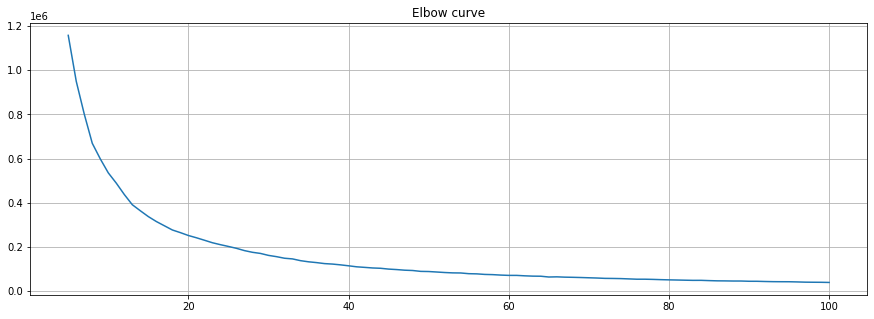

In [29]:
from sklearn import preprocessing
print("##"*30)
print("K-Means Clustering")
print("##"*30)
# 시도해 볼 cluster 수
cluster_number = range(5,101)
distortions = []
processed_data = doc_vec_100.copy()
scaler = preprocessing.MinMaxScaler()
#scaler.fit_transform(docvecmodel.docvecs.vectors_docs)
scaler.fit_transform(df)

# 모델 학습
for k in cluster_number:
    Clustering_Method = KMeans(n_clusters=k, random_state = 0)
    #X = model.docvecs.vectors_docs 
    #Clustering_Method.fit(docvecmodel.docvecs.vectors_docs)
    Clustering_Method.fit(df)
    distortions.append(Clustering_Method.inertia_)
    
# Elbow Curve 시각화
fig = plt.figure(figsize=(15, 5))
plt.plot(cluster_number, distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [61]:
Clustering_Method.labels_

array([7, 2, 1, ..., 1, 1, 5], dtype=int32)

In [12]:
from math import*
def euclidean_distance(x, y):
    return sqrt(sum(pow(a - b, 2) for a, b in zip(x, y)))

In [13]:
from sklearn import preprocessing
Clustering_Method = KMeans(n_clusters=10, random_state=0)
X = docvecmodel.docvecs.vectors_docs # document vector 전체를 가져옴. 
#processed_data = tsnedata.copy()
scaler = preprocessing.MinMaxScaler()
scaler.fit_transform(X)
Clustering_Method.fit(X)# fitting 
count = 0
#Clustering_Method.cluster_centers_
cluster_dict = {i:[] for i in range(0, 10)}
for text, label in zip(range(len(doc_vec_100)), Clustering_Method.labels_):
    a = []
    a.append(doc_vec_100['convrs'].loc[text])
    a.append([doc_vec_100['text'].loc[text]])
    a.append([doc_vec_100['trained_vector'].loc[text]])
    #a.append([doc_vec_100['tsne_x'].loc[text],doc_vec_100['tsne_y'].loc[text]])
    cluster_dict[label].append(a)
    

item_all_doc2vec = pd.DataFrame(columns = ['cluster','convrs','vec','distance','token'])
for (label, lst), y in zip(cluster_dict.items(),Clustering_Method.cluster_centers_):
    item = pd.DataFrame(columns = ['cluster','convrs','vec','distance','token'])
    print(f"Cluster {label}")
    for x in lst:
          token = str(x[1][0])
          vec = str(x[2][0])
          #print(x[2])
          #print(y)
          print(x[0])
          distance = euclidean_distance(x[2][0],y)
          new_df = pd.DataFrame({'cluster':label,
                                'vec': vec,
                                'token': token,
                                'convrs':x[0],
                                'distance': distance},index = [0])
          count+=1
          item = pd.concat([item,new_df], ignore_index = True)
    item = item.sort_values('distance')
    item_all_doc2vec = pd.concat([item_all_doc2vec, item], ignore_index = True)
    print("--"*30)
print(count)
print("##"*20)

Cluster 0
 같은 실내 게임처럼  우리가 생각하는 게 변화가 되고 있다는 얘기지
 경험했던 스포츠 중에 제일 기억에 남는 것이 있니
 그런 것도 운동 하면은 재밌기는 하지 일단 우리는 지금 너 쉬고 있을 때 정해야지
 대단한 것은 아니고 당구나 볼링  야구 정도
 대학교 다닐 때 친구들하고 같이 당구를 제법 많이 쳤는데
 어느 운동을 해도 들어가는 게 다 있어  마찬가지고
 재미는 있는데 내가 지금 이 시간에 왜  있나 이런 생각이 조금 들어
 하는 것보다는 구경하는 쪽을 많이 하고 탁구도 많이 쳤던 거 같아요
각자 개인이 치는 것도 좋지만 부부가 취미생활을 같이 하는 것도 좋은 거 같아
같이 모여서 볼링 하는 건 하다 보니까 분위기도 굉장히 좋아지고
걷는 것도 호흡이 맞아야 산에 둘이 가는 것도 발이 맞아야 재미있지
게임을 보면 시간 가는 줄을 모르겠어 그런데 꼭 배우고 싶거나 하진 않아
겨울에 추운데 물속에 바지 걷고 들어가고 얼마나 운동을 많이 했는지 몰라
골프 치는 사람이 예전에는 거의 없다 보니까 옛날에는 자랑거리 중에 하나였어
골프 친 다음에 씻으러 사우나를 들어가는데  거기서 재미있는  많았어
골프도 자기가 관심을 갖고 해 보고 싶어 하니까 나도 해 볼까 한 거지
골프도 하고 싶고  볼링  수영 뭐 그런 것은 그냥 늘상 접하는 걸로 하고 싶어
골프를 친 다음에 씻으러 사우나를 들어가는데 거기서 재미있는 일화들이 많았어
골프에 관심을 먼저 가진 사람이 자기니까 자기가 먼저 배우는 게 낫지
공이 종점에서 딱 거기 있을 때 때리니까 잘 들어가더라고
괜히 짜고 치는 거 같아서  그래서 이것들하고 다시는 당구를 치지 말아야지
괜히 짜고 치는 것 같아서 그래서 이것들하고는 다시는 당구를 치지 
그 거리를 하면 정말 재미있게 내가 골프를 즐기면서 칠 텐데
그 어느 한계에 딱 부딪혀서  그걸 더 이상 넘지 못 하고 포기한 것 같아요
그 정도로 물속에서 힘든 운동을 한 거지 그래도 운동하는 동안은 재미있었어
그 친구가 열심히 치고 있는데 나보고도 배우라고 

In [14]:
item_all_doc2vec

,cluster,convrs,vec,distance,token
0,0,볼링은 그다지 돈이 많이 들어가는 운동도 아니고 둘이 가서 쳐도 되잖아,[-0.02912747 0.05574499 -0.11671729 -0.055146...,0.352180,"['볼링', '들어가', '운동']"
1,0,특히 남들이 자주 하는 당구 같이 공 가지고 노는 건 잘 못 하는 것 같아요,[-0.02357598 -0.00619512 -0.01140515 -0.008725...,0.362928,"['당구', '가지']"
2,0,우리는 그나마 서울 가서 접하다 보니까 실내 운동을 자주 하게 되었지,[-0.13205142 -0.04899629 -0.053169 0.025670...,0.366977,"['서울', '접하', '실내', '운동']"
3,0,아니 나도 마찬가지야 나도 똑같애,[-0.0498949 0.00669677 -0.05939449 -0.020129...,0.367567,"['마찬가지', '똑같']"
4,0,그냥 골프를 더 하고 싶은데 돈 생각했을 때 볼링을 하자고 하는 거야,[-0.02610049 0.02936495 -0.1398777 -0.098146...,0.389013,"['골프', '생각', '볼링']"
...,...,...,...,...,...
3654,9,이렇게 막 늘고 올라가고 거리도 늘고 그러면 정말 재밌을텐데,[-0.27430397 0.06120273 0.00758191 0.173046...,1.182261,"['올라가', '거리', '그러', '재밌']"
3655,9,눈에 보이는 뭔가가 확연하게 있으면 좋은 건데 어쨌든 즐기다 보면 결과는 나오니까요,[-0.269234 -0.07628988 0.00784358 -0.065257...,1.187093,"['보이', '확연', '즐기', '결과', '나오']"
3656,9,당신이 관심을 보이면 반응들이 있겠지 그것도 괜찮은 방법인 것 같은데,[-0.19231983 0.01907045 -0.10056674 0.034163...,1.264002,"['관심', '보이', '반응', '괜찮', '방법']"
3657,9,한국 사람들은 등산으로 겨울 산에 올라가는데 장비가 완전 엘레베스트 급이라고,[ 1.29508451e-01 8.92437901e-03 -5.35883345e-...,1.350642,"['한국', '사람', '등산', '겨울', '올라가', '장비', '완전', '엘..."


In [15]:
item_all_doc2vec.drop(item_all_doc2vec[item_all_doc2vec['distance']>1.0].index, inplace = True)

In [16]:
item_all_doc2vec

,cluster,convrs,vec,distance,token
0,0,볼링은 그다지 돈이 많이 들어가는 운동도 아니고 둘이 가서 쳐도 되잖아,[-0.02912747 0.05574499 -0.11671729 -0.055146...,0.352180,"['볼링', '들어가', '운동']"
1,0,특히 남들이 자주 하는 당구 같이 공 가지고 노는 건 잘 못 하는 것 같아요,[-0.02357598 -0.00619512 -0.01140515 -0.008725...,0.362928,"['당구', '가지']"
2,0,우리는 그나마 서울 가서 접하다 보니까 실내 운동을 자주 하게 되었지,[-0.13205142 -0.04899629 -0.053169 0.025670...,0.366977,"['서울', '접하', '실내', '운동']"
3,0,아니 나도 마찬가지야 나도 똑같애,[-0.0498949 0.00669677 -0.05939449 -0.020129...,0.367567,"['마찬가지', '똑같']"
4,0,그냥 골프를 더 하고 싶은데 돈 생각했을 때 볼링을 하자고 하는 거야,[-0.02610049 0.02936495 -0.1398777 -0.098146...,0.389013,"['골프', '생각', '볼링']"
...,...,...,...,...,...
3640,9,그렇게 사회 생활 하면서 다른 거에 돈 허투루 쓰지 않으면 충분히 괜찮을 것 같아,[ 1.64258182e-01 1.09748140e-01 -2.00439155e-...,0.977734,"['사회', '생활', '괜찮']"
3641,9,보통 이제 잘 하는 사람만 키우고 못하는 사람은 신경 안 쓰는 약간 그런 부분이 있잖아,[-0.14124419 -0.04662704 -0.10502296 0.012744...,0.991872,"['보통', '사람', '키우', '사람', '신경', '부분']"
3642,9,예전에는 그걸 보더라도 그런 자세한 부분이 보이지 않았었거든요,[-0.15273044 0.03646474 -0.11797226 -0.078219...,0.993304,"['예전', '부분', '보이']"
3643,9,홀이라고 하던데 홀에 나가서 골프를 치면 참 멋있어 보이고 운동도 된다든데,[-0.13481551 0.07439445 0.08070605 -0.199738...,0.994106,"['나가', '골프', '멋있', '보이', '운동']"


In [17]:
import matplotlib.pyplot as plt

# class target 정보 불러오기 
tsnedata['target'] = Clustering_Method.labels_

# target 별 분리
tsne_df_0 = tsnedata[tsnedata['target'] == 0]
tsne_df_1 = tsnedata[tsnedata['target'] == 1]
tsne_df_2 = tsnedata[tsnedata['target'] == 2]
tsne_df_3 = tsnedata[tsnedata['target'] == 3]
tsne_df_4 = tsnedata[tsnedata['target'] == 4]
tsne_df_5 = tsnedata[tsnedata['target'] == 5]
tsne_df_6 = tsnedata[tsnedata['target'] == 6]
tsne_df_7 = tsnedata[tsnedata['target'] == 7]
tsne_df_8 = tsnedata[tsnedata['target'] == 8]
tsne_df_9 = tsnedata[tsnedata['target'] == 9]


# target 별 시각화
plt.scatter(tsne_df_0['x'], tsne_df_0['y'], color = 'red', label = '0')
plt.scatter(tsne_df_1['x'], tsne_df_1['y'], color = 'orange', label = '1')
plt.scatter(tsne_df_2['x'], tsne_df_2['y'], color = 'yellow', label = '2')
plt.scatter(tsne_df_3['x'], tsne_df_3['y'], color = 'green', label = '3')
plt.scatter(tsne_df_4['x'], tsne_df_4['y'], color = 'blue', label = '4')
plt.scatter(tsne_df_5['x'], tsne_df_5['y'], color = 'navy', label = '5')
plt.scatter(tsne_df_6['x'], tsne_df_6['y'], color = 'pink', label = '6')
plt.scatter(tsne_df_7['x'], tsne_df_7['y'], color = 'purple', label = '7')
plt.scatter(tsne_df_8['x'], tsne_df_8['y'], color = 'grey', label = '8')
plt.scatter(tsne_df_9['x'], tsne_df_9['y'], color = 'black', label = '9')


plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

NameError: ignored

In [28]:
inw = item_all_doc2vec.loc[item_all_doc2vec['cluster']==9]
inw[:50]

,cluster,convrs,vec,distance,token
3077,9,어느 날 나는 할까 봐 수영은 못 하겠어 이랬더니 같이 하는 사람이,[-0.02763233 -0.0331251 0.01496232 -0.012836...,0.197142,"['수영', '사람']"
3078,9,그 사람들이 자기한테 내가 이거 사 줄게 같이 골프 칩시다 말했다고 쳐,[-0.0575423 -0.03980185 -0.05527792 -0.050961...,0.211574,"['사람', '골프']"
3079,9,그래서 골프를 배워 볼까 하고 있는데 어때 한번 골프 배워볼래,[-0.06476153 -0.05755349 -0.0637164 -0.073997...,0.212484,"['골프', '골프']"
3080,9,그러니까 골프도 그냥 타고 나서 하다 보니까 그냥 되는구나 하고 생각했어요,[-4.96221334e-02 -3.33750620e-02 -5.20281717e-...,0.216158,"['골프', '생각']"
3081,9,하여간 그냥 있는 것 보다도 뭐라고 해야해 골프를 치든 수영을 하든,[ 0.00423631 -0.03166663 0.00290115 -0.039529...,0.219917,"['골프', '수영']"
3082,9,저 사람 때문에 내가 못 했다고 하는 생각에 화가 나는 거야,[-4.27132994e-02 -8.96028336e-03 -4.00055684e-...,0.222928,"['사람', '생각']"
3083,9,친구들한테 한번 알아봐요 나도 골프 한번 해 보려고 한다 뭐부터 해야 되냐,[-0.01735557 -0.04019849 -0.04780468 -0.063968...,0.224075,"['친구', '골프']"
3084,9,그래서 어제 봤던 사람도 이년 반밖에 안 됐는데 친구들이랑 가면,[-0.02833207 -0.02540823 -0.05109729 -0.064210...,0.248782,"['사람', '친구']"
3085,9,골프도 운동 중에 운동이지만 골프는 이제 돈이 좀 드는 편이잖아,[-0.02940122 -0.01080786 -0.08029555 -0.096924...,0.256289,"['골프', '운동', '운동', '골프']"
3086,9,골프라는 게 혼자 치는 게 아니라 팀으로 쳐야 하니까 애매한 거죠,[-0.01990253 -0.0303638 -0.02894829 -0.041291...,0.257760,['골프']


In [37]:
for i in range(10):
  inw = item_all_doc2vec.loc[item_all_doc2vec['cluster']==i]
  # 조건에 맞는 행제거 (df)
  print(len(inw))


idx = item_all_doc2vec[item_all_doc2vec['cluster']==1].index
item_all_doc2vec = item_all_doc2vec.drop(idx)

idx = item_all_doc2vec[item_all_doc2vec['cluster']==8].index
item_all_doc2vec = item_all_doc2vec.drop(idx)

304
489
174
287
343
547
218
203
217
145


In [ ]:
for i in range(10):
  inw = item_all_doc2vec.loc[item_all_doc2vec['cluster']==i]
  # 조건에 맞는 행제거 (df)
  print(len(inw))

542
0
289
246
231
170
181
160
0
278


In [30]:
item_all_doc2vec.to_csv('item_all_스포츠.csv')